In [ ]:
!pip install keras-tuner --upgrade

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
import keras_tuner as kt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
import os
os.environ['PYTHONHASHSEED']=str(2110)
tf.random.set_seed(2110)


In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total  --format=csv

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#Analise Exploratória de dados

In [ ]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0).iloc[:,1:]

V1 = np.array(dados_crus.pop('Semenov'))
V2 = np.array(dados_crus.pop('T_Limite'))

Labels = []
for i in range(len(V1)):
  if V1[i] > 0 or V2[i]> 0:
    Labels.append(1)
  else:
    Labels.append(0)

Labels = np.array(Labels)

dados_crus

Tempo      Conc    T_Reator  ...       Ffj           Qm           Qr
0         0.000000  2.000000  311.150000  ...  1.524363    18.037788   135.694981
1         0.606061  1.978296  310.158835  ...  1.524363    16.253297   129.292939
2         1.212121  1.957900  309.208465  ...  1.524363    14.701465   123.177082
3         1.818182  1.938686  308.298080  ...  1.524363    13.347991   117.338962
4         2.424242  1.920547  307.426707  ...  1.524363    12.164007   111.769557
...            ...       ...         ...  ...       ...          ...          ...
4665595  57.575758  0.000003  819.283815  ...  6.360796  1968.714364  2073.853047
4665596  58.181818  0.000003  819.309267  ...  6.360796  1968.714364  2073.760912
4665597  58.787879  0.000003  819.333491  ...  6.360796  1968.714364  2073.673176
4665598  59.393939  0.000003  819.356547  ...  6.360796  1968.714364  2073.589632
4665599  60.000000  0.000003  819.378490  ...  6.360796  1968.714364  2073.510081

[4665600 rows x 21 columns]

In [ ]:
dados_crus.describe()

Tempo          Conc  ...            Qm            Qr
count  4.665600e+06  4.665600e+06  ...  4.665600e+06  4.665600e+06
mean   3.000000e+01  1.850084e+00  ...  3.087708e+02  3.047672e+02
std    1.749459e+01  1.700616e+00  ...  4.920795e+03  4.697933e+02
min    0.000000e+00  1.266563e-06  ...  1.214624e+00 -6.671002e+01
25%    1.500000e+01  1.129813e-02  ...  1.212015e+01  1.387602e+01
50%    3.000000e+01  1.829814e+00  ...  4.489911e+01  4.397579e+01
75%    4.500000e+01  2.788471e+00  ...  3.989778e+02  4.893158e+02
max    6.000000e+01  6.240595e+00  ...  9.687765e+06  2.369480e+03

[8 rows x 21 columns]

In [ ]:
print('{:.2%} of data consist of runaway instances'.format(Labels.sum() / len(dados_crus)))

23.82% of data consist of runaway instances


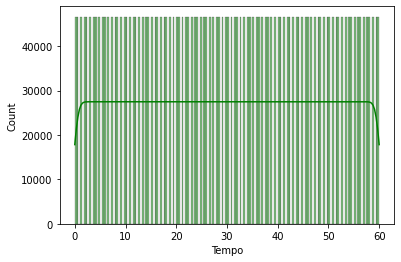

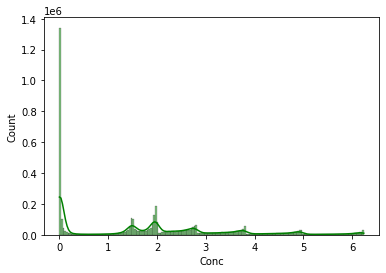

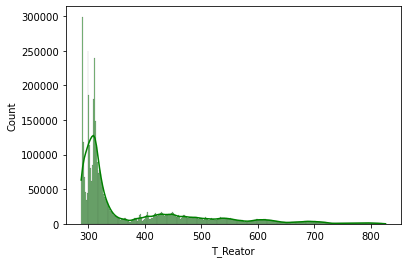

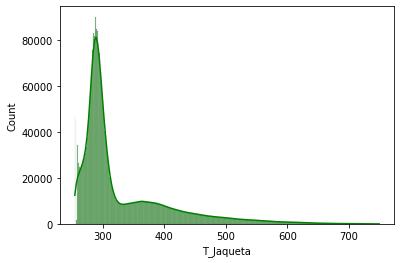

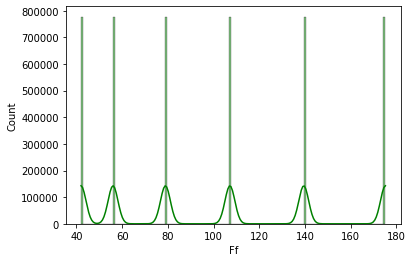

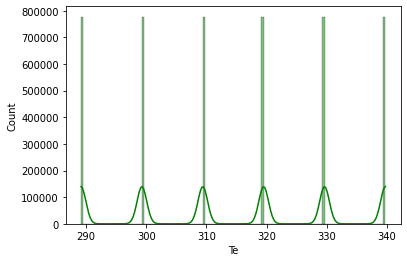

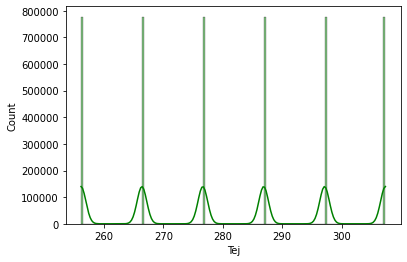

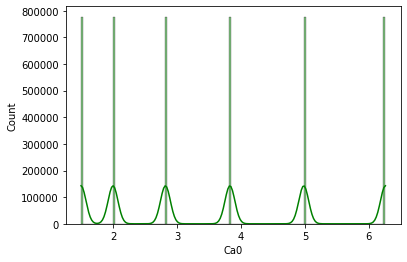

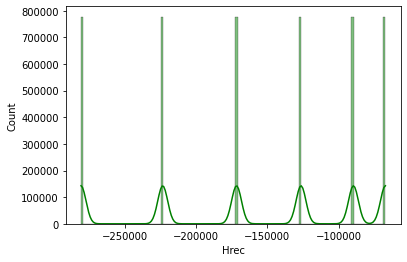

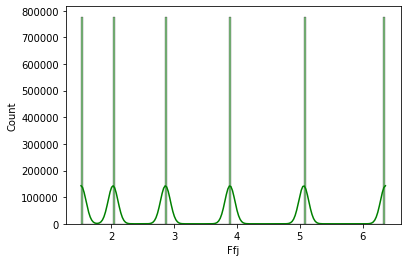

In [ ]:
sns.color_palette("pastel")
for i in ['Tempo','Conc','T_Reator','T_Jaqueta','Ff','Te','Tej','Ca0','Hrec','Ffj']:
  sns.histplot(dados_crus[i],kde=True, color='green')
  plt.show()

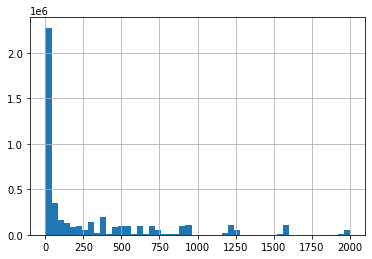

In [ ]:
dados_crus.query('Qm < 2e3')["Qm"].hist(bins=50) # There are some big occurrences of heat made in the reactor

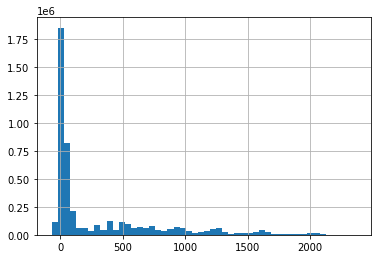

In [ ]:
dados_crus["Qr"].hist(bins=50) # Heat removed by the jacket

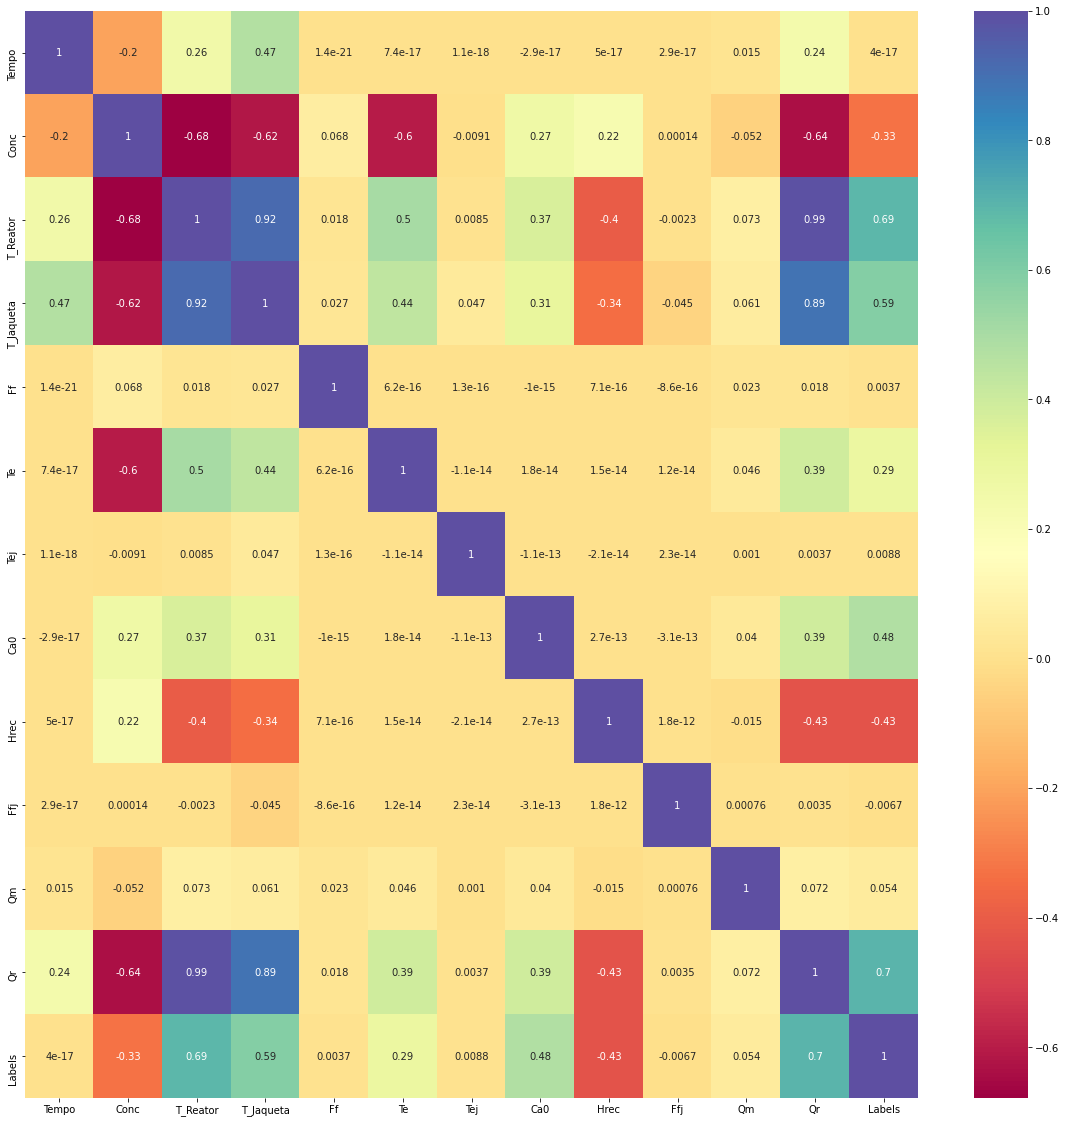

In [ ]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0).iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21]]
dados_crus['Labels'] = Labels

plt.figure(figsize=(20,20))
sns.heatmap(dados_crus.corr(),annot=True,cmap='Spectral')

In [ ]:
sns.pairplot(dados_crus)

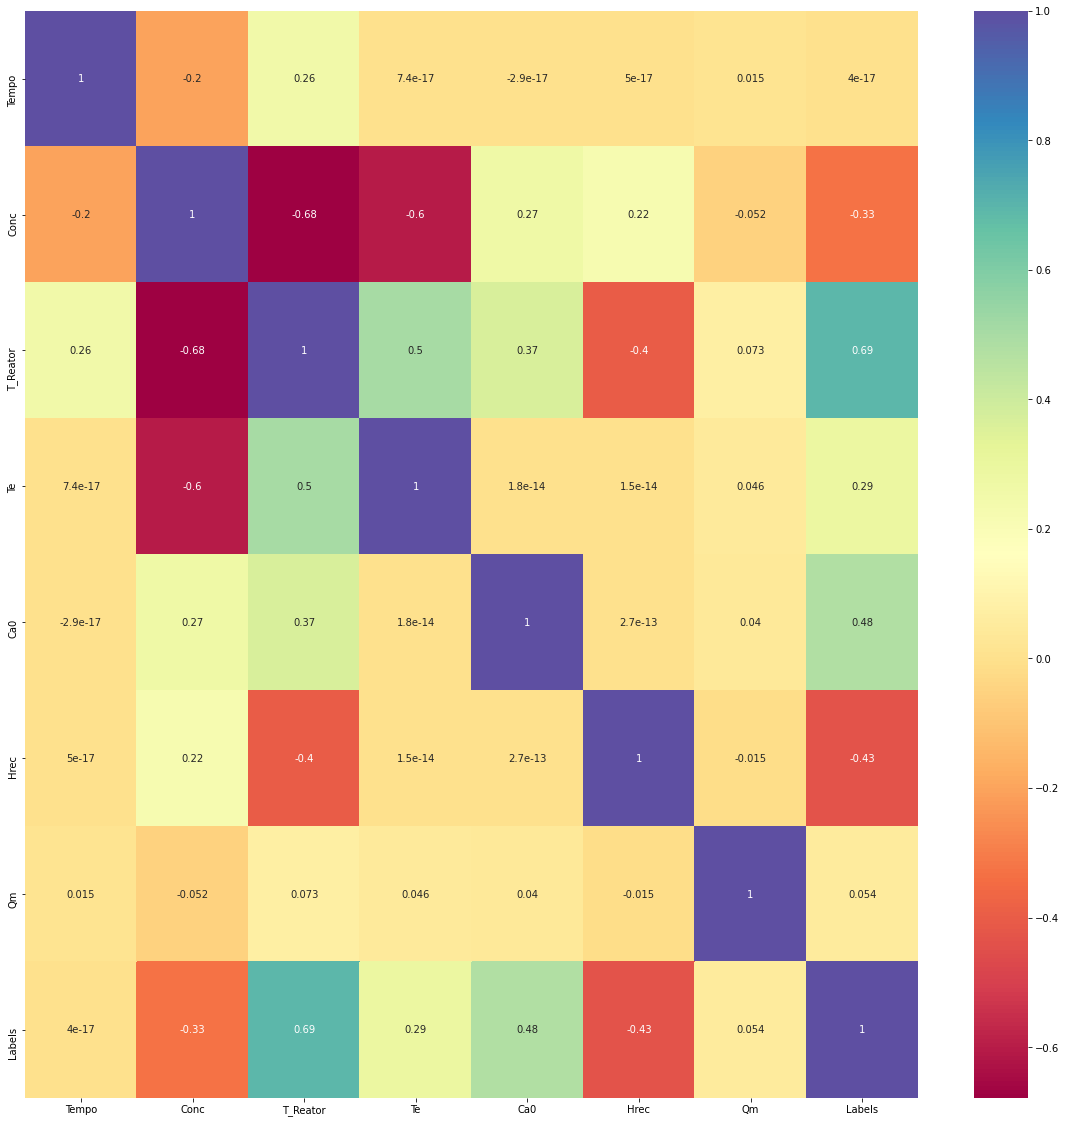

In [ ]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0).iloc[:, [1,2,3,7,10,12,20]]
dados_crus['Labels'] = Labels

plt.figure(figsize=(20,20))
sns.heatmap(dados_crus.corr(),annot=True,cmap='Spectral')

**Há uma diferença imensa no desempenho dos métodos de árvore dropando as colunas muito correlacionadas. PARA PCA FILTRAR AJUDOU A CONVERGIR, JÁ NOS DADOS NORMAIS ATRAPALHOU COMPLETAMENTE A CLASSIFICAÇÃO**

# Normal Dataset (Filtrado e Normalizado)

In [3]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0)
#dados_crus = dados_crus.iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21,-1,-2]]
dados_crus = dados_crus.iloc[:, [1,2,3,7,10,12,20,-1,-2]]
V1 = np.array(dados_crus.pop('Semenov'))
V2 = np.array(dados_crus.pop('T_Limite'))

Labels = []
for i in range(len(V1)):
  if V1[i] > 0 or V2[i]> 0:
    Labels.append(1)
  else:
    Labels.append(0)

Labels = np.array(Labels)
dados_crus['Labels'] = Labels

In [4]:
scaler = StandardScaler()

df_runaway = dados_crus.query('Labels > 0')

test_dataset_runaway = df_runaway.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp = dados_crus.drop(df_runaway.index) #ou .query / Operações normais

test_dataset_NormalOp = NormalOp.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) # outra metade com instâncias normais de operação

Test_dataset = pd.concat([test_dataset_runaway,test_dataset_NormalOp])    # Dataset de Teste

Train_dataset = dados_crus.drop(Test_dataset.index)   


Test_dataset_Labels = Test_dataset.pop('Labels')


Train_dataset_Labels = Train_dataset.pop('Labels') # Dataset de Treino



Train_dataset = scaler.fit_transform(Train_dataset)
Test_dataset = scaler.fit_transform(Test_dataset)

In [17]:
Train_dataset.shape

(4618944, 7)

#Normal Dataset Completo

In [3]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0)
dados_crus = dados_crus.iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21,-1,-2]]
#dados_crus = dados_crus.iloc[:, [1,2,3,7,10,12,20,-1,-2]]
V1 = np.array(dados_crus.pop('Semenov'))
V2 = np.array(dados_crus.pop('T_Limite'))

Labels = []
for i in range(len(V1)):
  if V1[i] > 0 or V2[i]> 0:
    Labels.append(1)
  else:
    Labels.append(0)

Labels = np.array(Labels)
dados_crus['Labels'] = Labels

In [4]:
scaler = StandardScaler()

df_runaway = dados_crus.query('Labels > 0')

test_dataset_runaway = df_runaway.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp = dados_crus.drop(df_runaway.index) #ou .query / Operações normais

test_dataset_NormalOp = NormalOp.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) # outra metade com instâncias normais de operação

Test_dataset_F = pd.concat([test_dataset_runaway,test_dataset_NormalOp])    # Dataset de Teste

Train_dataset_F = dados_crus.drop(Test_dataset_F.index)   


Test_dataset_Labels_F = Test_dataset_F.pop('Labels')


Train_dataset_Labels_F = Train_dataset_F.pop('Labels') # Dataset de Treino



Train_dataset_F = scaler.fit_transform(Train_dataset_F)
Test_dataset_F = scaler.fit_transform(Test_dataset_F)

In [24]:
Train_dataset_F.shape

(4618944, 12)

# Dataset_PCA Filtrado

In [16]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0)
dados_crus = dados_crus.iloc[:, [1,2,3,7,10,12,20,-1,-2]]

dados_crus.pop('Semenov')
dados_crus.pop('T_Limite')


X_reduced = pd.DataFrame(dados_crus)
pca = PCA(n_components=5)
X_reduced = pd.DataFrame(pca.fit_transform(X_reduced))

X_reduced['Labels'] = Labels
dados_crus['Labels'] = Labels

df_runaway_PCA = X_reduced.query('Labels > 0')


test_dataset_runaway_PCA = df_runaway_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp_PCA = X_reduced.drop(df_runaway_PCA.index) #ou .query

test_dataset_NormalOp_PCA = NormalOp_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #outra metade com instâncias comuns de operação

Test_dataset_PCA = pd.concat([test_dataset_runaway_PCA,test_dataset_NormalOp_PCA])

Train_dataset_PCA = X_reduced.drop(Test_dataset_PCA.index)

Test_dataset_PCA_Labels = Test_dataset_PCA.pop('Labels')

Train_dataset_PCA_Labels = Train_dataset_PCA.pop('Labels')


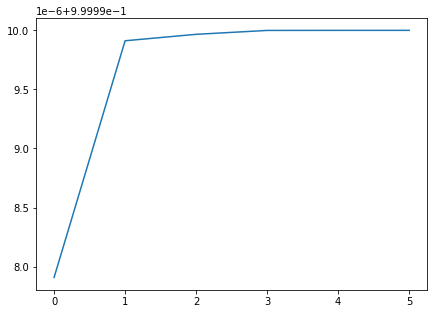

In [30]:
plt.figure(figsize=(7,5))
pca_dummy = PCA(n_components=None)
X_dummy = dados_crus.iloc[:,:-1]
X_dummy = pca_dummy.fit_transform(X_dummy)
plt.plot(np.cumsum(pca_dummy.explained_variance_ratio_)[1:])

In [31]:
np.cumsum(pca_dummy.explained_variance_ratio_)

array([0.9956681 , 0.99999791, 0.99999991, 0.99999997, 1.        ,
       1.        , 1.        ])

In [33]:
Train_dataset_PCA.shape

(4618944, 5)

#Dataset_PCA Completo

In [5]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0)
dados_crus = dados_crus.iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21,-1,-2]]

dados_crus.pop('Semenov')
dados_crus.pop('T_Limite')


X_reduced = pd.DataFrame(dados_crus)
pca = PCA(n_components=8)
X_reduced = pd.DataFrame(pca.fit_transform(X_reduced))

X_reduced['Labels'] = Labels
dados_crus['Labels'] = Labels

df_runaway_PCA = X_reduced.query('Labels > 0')


test_dataset_runaway_PCA = df_runaway_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp_PCA = X_reduced.drop(df_runaway_PCA.index) #ou .query

test_dataset_NormalOp_PCA = NormalOp_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #outra metade com instâncias comuns de operação

Test_dataset_PCA_F = pd.concat([test_dataset_runaway_PCA,test_dataset_NormalOp_PCA])

Train_dataset_PCA_F = X_reduced.drop(Test_dataset_PCA_F.index)

Test_dataset_PCA_Labels_F = Test_dataset_PCA_F.pop('Labels')

Train_dataset_PCA_Labels_F = Train_dataset_PCA_F.pop('Labels')


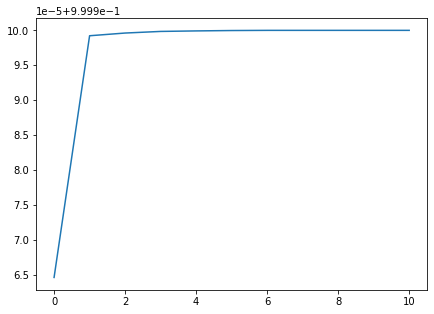

In [6]:
plt.figure(figsize=(7,5))
pca_dummy = PCA(n_components=None)
X_dummy = dados_crus.iloc[:,:-1]
X_dummy = pca_dummy.fit_transform(X_dummy)
plt.plot(np.cumsum(pca_dummy.explained_variance_ratio_)[1:])

In [40]:
np.cumsum(pca_dummy.explained_variance_ratio_)

array([0.99563482, 0.99996463, 0.99999923, 0.99999962, 0.99999985,
       0.99999992, 0.99999997, 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [37]:
Train_dataset_PCA_F.shape

(4618944, 5)

# Reducing Datasets

Vou usar nosso dataset de treino para criar datasets de treino e validação reduzidos


In [17]:
Train_dataset_PCA_Reduced , Test_dataset_PCA_reduced , Train_dataset_PCA_Labels_Reduced, Test_dataset_PCA_Labels_reduced = train_test_split(
    Test_dataset_PCA, Test_dataset_PCA_Labels,
    random_state=0,test_size=0.1)


Train_dataset_Reduced , Test_dataset_reduced , Train_dataset_Labels_Reduced, Test_dataset_Labels_reduced = train_test_split(
    Test_dataset, Test_dataset_Labels,
    random_state=0,test_size=0.1)

In [8]:
print(Train_dataset_PCA_Reduced.shape[0]/ X_reduced.shape[0]*100,'% of dataset used to train')

0.8999914266117969 % of dataset used to train


In [10]:
Train_dataset_PCA_Reduced

0           1           2          3          4
1563612  -92605.163851 -202.855360   15.758725 -18.232029  12.751084
3723449   63571.500560 -353.522659  116.909733   6.643224   1.950772
2289251  120842.610964  111.161870 -156.174366 -10.586600  -7.218338
1523505  120841.894112 -411.834798  146.658626 -17.312066  10.459476
2841094   11795.785734  151.323139 -171.658044  30.441044  19.644919
...                ...         ...         ...        ...        ...
1475598  120842.307667 -147.914632  -93.152022  15.215719 -26.231924
1681541  -92605.180623 -208.369097   34.694957   6.477271  21.756947
1767505  -70180.096379 -153.644103   10.611708 -35.260222 -12.160368
2233509  120841.893114 -413.776677  144.074496 -19.540275   0.382611
3620429   11795.762191  151.298591 -134.819516 -18.142147   5.639482

[41990 rows x 5 columns]

# Cont

In [9]:
Labels.sum()/ dados_crus.shape[0]  # 23.8% do dataset é de classe runaway

0.23823302469135801

In [10]:
test_dataset_runaway.shape

(23328, 8)

In [11]:
test_dataset_NormalOp.shape

(23328, 8)

In [12]:
Test_dataset.shape

(46656, 7)

In [13]:
Test_dataset_PCA.shape

(46656, 5)

In [14]:
dados_crus.shape

(4665600, 8)

In [15]:
Test_dataset.shape[0]+Train_dataset.shape[0]

4665600

In [16]:
len(Labels)

4665600

 **Antes de prosseguir com outra classificação, reinicie o kernel** 

# TensorFlow / Keras

## Normal Dataset Train (Tratado)

In [41]:
model=keras.Sequential()

model.add(keras.layers.Dense(64,input_shape=[7],  #Preferi deixar o input_shape no manual para evitar confusão
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(8,activation = 'LeakyReLU'))



model.add(keras.layers.Dense(1, activation='sigmoid'))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2

In [43]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])

**Please restart your kernel for every fit**

In [45]:
history = model.fit(x=Train_dataset,
                    y=Train_dataset_Labels,validation_data = (Test_dataset,Test_dataset_Labels)
                    ,validation_steps = len(Test_dataset)/256 ,epochs = 12 ,batch_size=256,verbose=1
                    )

Epoch 1/12
18043/18043 [==============================] - 79s 4ms/step - loss: 0.3808 - accuracy: 0.8523 - auc: 0.9067 - false_negatives: 226048.0000 - val_loss: 0.3939 - val_accuracy: 0.8142 - val_auc: 0.9594 - val_false_negatives: 8536.0000
Epoch 2/12
18043/18043 [==============================] - 82s 5ms/step - loss: 0.1873 - accuracy: 0.9511 - auc: 0.9851 - false_negatives: 133174.0000 - val_loss: 0.4029 - val_accuracy: 0.8102 - val_auc: 0.9803 - val_false_negatives: 8854.0000
Epoch 3/12
18043/18043 [==============================] - 79s 4ms/step - loss: 0.1255 - accuracy: 0.9624 - auc: 0.9925 - false_negatives: 103094.0000 - val_loss: 0.4250 - val_accuracy: 0.8192 - val_auc: 0.9865 - val_false_negatives: 8436.0000
Epoch 4/12
18043/18043 [==============================] - 76s 4ms/step - loss: 0.0968 - accuracy: 0.9679 - auc: 0.9948 - false_negatives: 82655.0000 - val_loss: 0.4471 - val_accuracy: 0.8208 - val_auc: 0.9881 - val_false_negatives: 8357.0000
Epoch 5/12
18043/18043 [=====

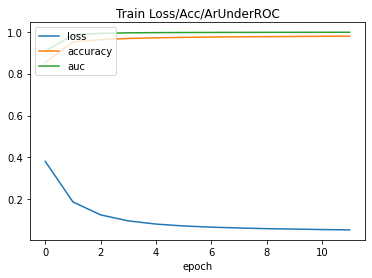

In [46]:
for i in ['loss', 'accuracy','auc']:
  plt.plot(history.history[i])
plt.title('Train Loss/Acc/ArUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='upper left')
plt.show()

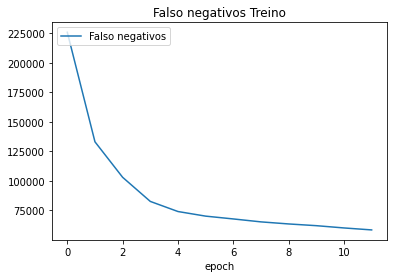

In [47]:
plt.plot(history.history['false_negatives'])
plt.title('Falso negativos Treino')

plt.xlabel('epoch')
plt.legend(['Falso negativos'], loc='upper left')
plt.show()

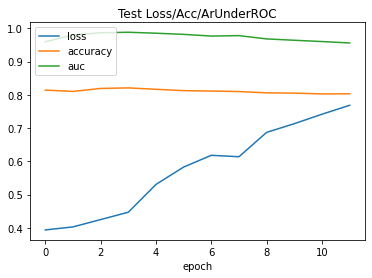

In [48]:
for i in ['val_loss', 'val_accuracy','val_auc']:
  plt.plot(history.history[i])
plt.title('Test Loss/Acc/ArUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='upper left')
plt.show()

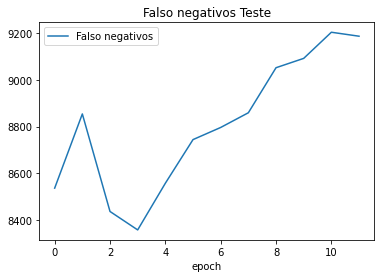

In [49]:
plt.plot(history.history['val_false_negatives'])
plt.title('Falso negativos Teste')

plt.xlabel('epoch')
plt.legend(['Falso negativos'], loc='upper left')
plt.show()

## Normal Dataset Train (Dataset não filtrado)

In [9]:
model2=keras.Sequential()

model2.add(keras.layers.Dense(64,input_shape=[12],  #Preferi deixar o input_shape no manual para evitar confusão
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model2.add(keras.layers.BatchNormalization())

model2.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model2.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model2.add(keras.layers.BatchNormalization())

model2.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model2.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model2.add(keras.layers.BatchNormalization())

model2.add(keras.layers.Dense(8,activation = 'LeakyReLU'))



model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [10]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2

In [11]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])

**Please restart your kernel for every fit**

In [12]:
history2 = model2.fit(x=Train_dataset_F,
                    y=Train_dataset_Labels_F,validation_data = (Test_dataset_F,Test_dataset_Labels_F)
                    ,validation_steps = len(Test_dataset)/256 ,epochs = 12 ,batch_size=256,verbose=1
                    )

Epoch 1/12
18043/18043 [==============================] - 82s 4ms/step - loss: 0.3571 - accuracy: 0.8640 - auc: 0.9219 - false_negatives: 244638.0000 - val_loss: 0.3832 - val_accuracy: 0.8120 - val_auc: 0.9633 - val_false_negatives: 8621.0000
Epoch 2/12
18043/18043 [==============================] - 78s 4ms/step - loss: 0.1888 - accuracy: 0.9434 - auc: 0.9822 - false_negatives: 144345.0000 - val_loss: 0.3990 - val_accuracy: 0.8007 - val_auc: 0.9804 - val_false_negatives: 9270.0000
Epoch 3/12
18043/18043 [==============================] - 80s 4ms/step - loss: 0.1341 - accuracy: 0.9565 - auc: 0.9897 - false_negatives: 118595.0000 - val_loss: 0.4386 - val_accuracy: 0.7971 - val_auc: 0.9861 - val_false_negatives: 9454.0000
Epoch 4/12
18043/18043 [==============================] - 77s 4ms/step - loss: 0.1080 - accuracy: 0.9624 - auc: 0.9925 - false_negatives: 103612.0000 - val_loss: 0.4832 - val_accuracy: 0.7948 - val_auc: 0.9894 - val_false_negatives: 9562.0000
Epoch 5/12
18043/18043 [====

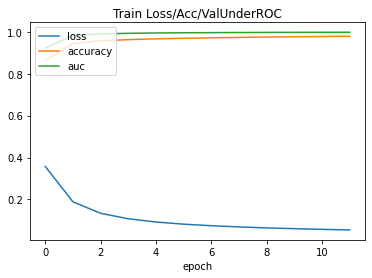

In [13]:
for i in ['loss', 'accuracy','auc']:
  plt.plot(history2.history[i])
plt.title('Train Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='upper left')
plt.show()

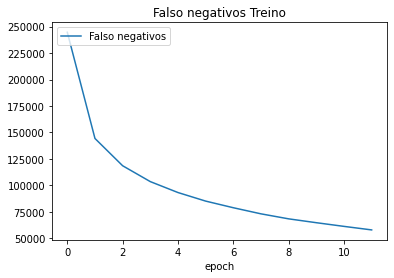

In [15]:
plt.plot(history2.history['false_negatives'])
plt.title('Falso negativos Treino')

plt.xlabel('epoch')
plt.legend(['Falso negativos'], loc='upper left')
plt.show()

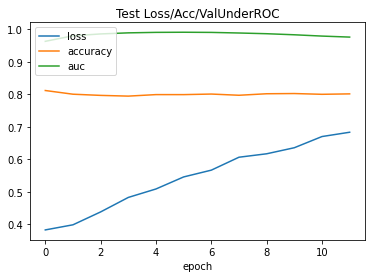

In [14]:
for i in ['val_loss', 'val_accuracy','val_auc']:
  plt.plot(history2.history[i])
plt.title('Test Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='upper left')
plt.show()

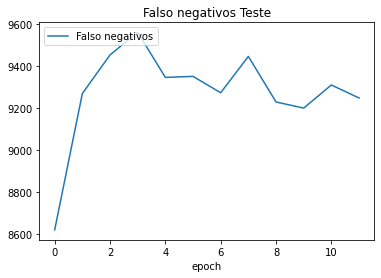

In [16]:
plt.plot(history2.history['val_false_negatives'])
plt.title('Falso negativos Teste')

plt.xlabel('epoch')
plt.legend(['Falso negativos'], loc='upper left')
plt.show()

## PCA Dataset Train (Tratado)

In [6]:
model3=keras.Sequential()

model3.add(keras.layers.Dense(64,input_shape=[5],
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model3.add(keras.layers.BatchNormalization())

model3.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model3.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model3.add(keras.layers.BatchNormalization())

model3.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model3.add(keras.layers.Dense(32,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model3.add(keras.layers.BatchNormalization())

model3.add(keras.layers.Dense(16,activation = 'LeakyReLU'))



model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [7]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                5

In [8]:
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])

**Please restart your kernel for every fit**

In [9]:
history3 = model3.fit(x=Train_dataset_PCA,y=Train_dataset_PCA_Labels,validation_data = (Test_dataset_PCA,Test_dataset_PCA_Labels),
                     validation_steps = len(Test_dataset)/256 ,epochs = 12 ,batch_size=256,verbose=1
                     )

Epoch 1/12
18043/18043 [==============================] - 80s 4ms/step - loss: 0.2509 - accuracy: 0.8993 - auc: 0.9338 - false_negatives: 322669.0000 - val_loss: 0.3588 - val_accuracy: 0.8229 - val_auc: 0.9572 - val_false_negatives: 8181.0000
Epoch 2/12
18043/18043 [==============================] - 84s 5ms/step - loss: 0.1823 - accuracy: 0.9265 - auc: 0.9638 - false_negatives: 283728.0000 - val_loss: 0.2883 - val_accuracy: 0.8592 - val_auc: 0.9686 - val_false_negatives: 6455.0000
Epoch 3/12
18043/18043 [==============================] - 76s 4ms/step - loss: 0.1668 - accuracy: 0.9329 - auc: 0.9700 - false_negatives: 247803.0000 - val_loss: 0.3490 - val_accuracy: 0.8476 - val_auc: 0.9472 - val_false_negatives: 6928.0000
Epoch 4/12
18043/18043 [==============================] - 77s 4ms/step - loss: 0.1608 - accuracy: 0.9341 - auc: 0.9726 - false_negatives: 237555.0000 - val_loss: 0.7021 - val_accuracy: 0.8052 - val_auc: 0.7844 - val_false_negatives: 8692.0000
Epoch 5/12
18043/18043 [====

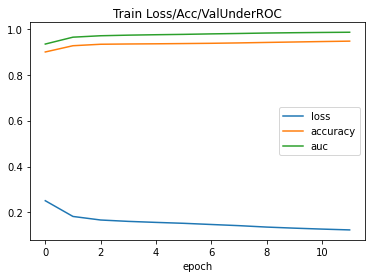

In [10]:
for i in ['loss', 'accuracy','auc']:
  plt.plot(history3.history[i])
plt.title('Train Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='best')
plt.show()

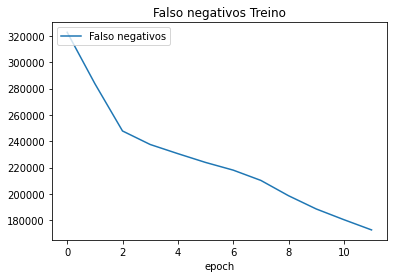

In [12]:
plt.plot(history3.history['false_negatives'])
plt.title('Falso negativos Treino')

plt.xlabel('epoch')
plt.legend(['Falso negativos'], loc='upper left')
plt.show()

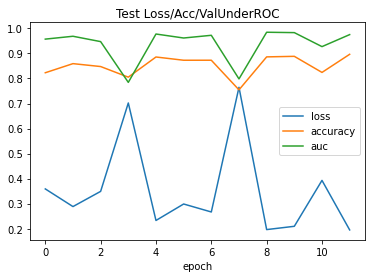

In [11]:
for i in ['val_loss', 'val_accuracy','val_auc']:
  plt.plot(history3.history[i])
plt.title('Test Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='best')
plt.show()

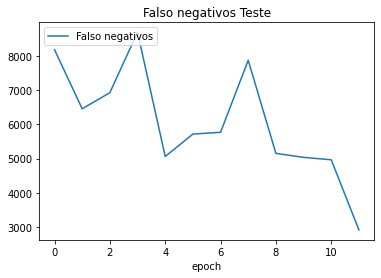

In [13]:
plt.plot(history3.history['val_false_negatives'])
plt.title('Falso negativos Teste')

plt.xlabel('epoch')
plt.legend(['Falso negativos'], loc='upper left')
plt.show()

##PCA Dataset Train (Dataset não filtrado)

In [6]:
model4=keras.Sequential()

model4.add(keras.layers.Dense(64,input_shape=[8],
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model4.add(keras.layers.BatchNormalization())

model4.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model4.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model4.add(keras.layers.BatchNormalization())

model4.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model4.add(keras.layers.Dense(32,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model4.add(keras.layers.BatchNormalization())

model4.add(keras.layers.Dense(16,activation = 'LeakyReLU'))



model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [7]:
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                5

In [8]:
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])

In [9]:
history4 = model4.fit(x=Train_dataset_PCA_F,y=Train_dataset_PCA_Labels_F,validation_data = (Test_dataset_PCA_F,Test_dataset_PCA_Labels_F),
                     validation_steps = len(Test_dataset_PCA_F)/256 ,epochs = 12 ,batch_size=256,verbose=1
                     )

Epoch 1/12
18043/18043 [==============================] - 78s 4ms/step - loss: 0.2373 - accuracy: 0.9050 - auc: 0.9433 - false_negatives: 287874.0000 - val_loss: 0.2887 - val_accuracy: 0.8563 - val_auc: 0.9672 - val_false_negatives: 6262.0000
Epoch 2/12
18043/18043 [==============================] - 75s 4ms/step - loss: 0.1568 - accuracy: 0.9328 - auc: 0.9760 - false_negatives: 216388.0000 - val_loss: 0.2125 - val_accuracy: 0.8987 - val_auc: 0.9787 - val_false_negatives: 3993.0000
Epoch 3/12
18043/18043 [==============================] - 77s 4ms/step - loss: 0.1456 - accuracy: 0.9351 - auc: 0.9797 - false_negatives: 201674.0000 - val_loss: 0.2075 - val_accuracy: 0.9000 - val_auc: 0.9738 - val_false_negatives: 3132.0000
Epoch 4/12
18043/18043 [==============================] - 75s 4ms/step - loss: 0.1380 - accuracy: 0.9365 - auc: 0.9820 - false_negatives: 195302.0000 - val_loss: 0.2824 - val_accuracy: 0.8578 - val_auc: 0.9531 - val_false_negatives: 3611.0000
Epoch 5/12
18043/18043 [====

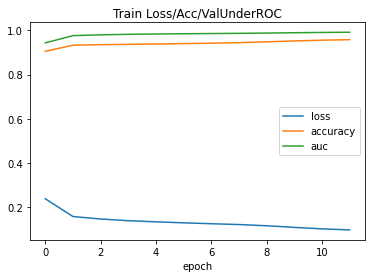

In [10]:
for i in ['loss', 'accuracy','auc']:
  plt.plot(history4.history[i])
plt.title('Train Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='best')
plt.show()

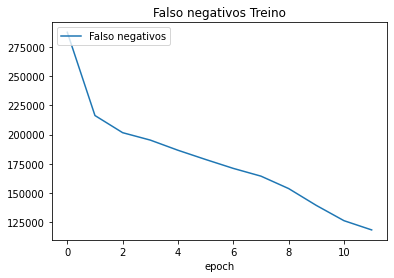

In [12]:
plt.plot(history4.history['false_negatives'])
plt.title('Falso negativos Treino')

plt.xlabel('epoch')
plt.legend(['Falso negativos'], loc='upper left')
plt.show()

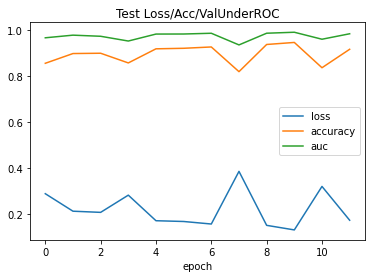

In [11]:
for i in ['val_loss', 'val_accuracy','val_auc']:
  plt.plot(history4.history[i])
plt.title('Test Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='best')
plt.show()

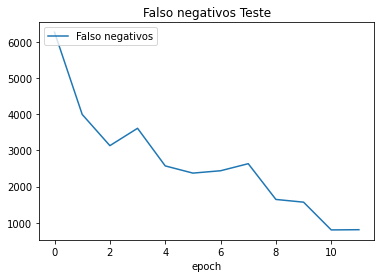

In [13]:
plt.plot(history4.history['val_false_negatives'])
plt.title('Falso negativos Teste')

plt.xlabel('epoch')
plt.legend(['Falso negativos'], loc='upper left')
plt.show()

## Confusion matrix

In [9]:
def plot_confusion_matrix(cm, classes,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.86925583 0.13074417]
 [0.03480796 0.96519204]]


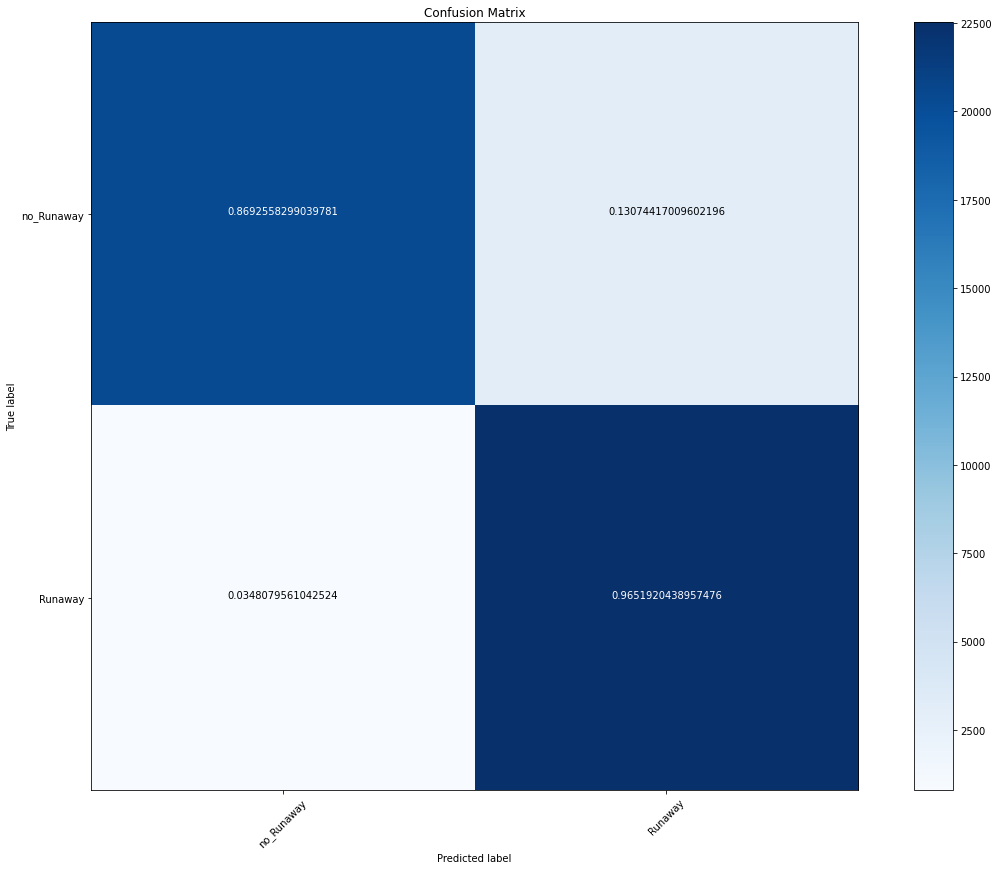

In [15]:
predictions = model4.predict(
      x=Test_dataset_PCA_F
    , batch_size=400
    , verbose=0
)  

rounded_predictions = np.argmax(predictions, axis=-1)

cm = confusion_matrix(y_true=Test_dataset_PCA_Labels_F, y_pred=predictions.round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


## Keras Tuner

In [7]:
def build_model(hp):
  model = keras.Sequential()

  model.add(keras.layers.Dense(
        hp.Choice('unitsPre1', [64]),
        bias_regularizer=regularizers.l1(1e-6),
        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6),
        activation='LeakyReLU'))
  
  model.add(keras.layers.Dense(
      hp.Choice('unitsPre2', [32, 64]),
      bias_regularizer=regularizers.l1(1e-6),
      kernel_regularizer=regularizers.l2(1e-5),
      activation='LeakyReLU'))
  
  for i in range(hp.Int('num_layers',4,6)):
    if i % 2 == 0:
      model.add(keras.layers.Dense(
        hp.Choice('units' + str(i), [16, 32]),

        bias_regularizer=regularizers.l1(1e-6),
        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6),
        activity_regularizer=regularizers.l2(1e-6),

        activation='LeakyReLU'))
      model.add(keras.layers.BatchNormalization())
    else:
      model.add(keras.layers.Dense(
          hp.Choice('units' + str(i), [16, 32]),
          activation='LeakyReLU'))
      
  
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-5])),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])
  #model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001
   #                                                   ,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad"),loss='binary_crossentropy',metrics=['mae','mse','accuracy'])
  
  return model

**Please restart your kernel for every fit**

In [64]:
tuner = kt.Hyperband(build_model,
                     seed=0,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=12,
                     factor=4,
                     directory='/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/',
                     project_name='Reactor_NN_Tuner_Hyperband_Final_PCA(8)',
                     overwrite=False)
tuner.search(Train_dataset_PCA_F, Train_dataset_PCA_Labels_F,
             validation_data=(Test_dataset_PCA_F, Test_dataset_PCA_Labels_F),
             validation_steps = len(Test_dataset_PCA_F)/400 ,batch_size=400)

Trial 11 Complete [00h 13m 24s]
val_accuracy: 0.9116726517677307

Best val_accuracy So Far: 0.9293767213821411
Total elapsed time: 01h 18m 53s
INFO:tensorflow:Oracle triggered exit


In [9]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband_Final_PCA(8)
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
unitsPre1: 64
unitsPre2: 32
num_layers: 6
units0: 32
units1: 16
units2: 16
units3: 32
learning_rate: 1e-05
units4: 16
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
units5: 16
Score: 0.9293767213821411
Trial summary
Hyperparameters:
unitsPre1: 64
unitsPre2: 32
num_layers: 5
units0: 16
units1: 16
units2: 32
units3: 32
learning_rate: 1e-05
units4: 16
units5: 32
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9122084975242615
Trial summary
Hyperparameters:
unitsPre1: 64
unitsPre2: 64
num_layers: 5
units0: 16
units1: 16
units2: 16
units3: 16
learning_rate: 1e-05
units4: 32
units5: 32
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9116726517677307
Trial summary
Hyperparameters:
unitsP

In [12]:
best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]
model = tuner.hypermodel.build(best_hps)
#model.load_weights(tf.train.latest_checkpoint('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband+2/trial_d816f1bbcd21a1c8c83d7ecfbca6dbd1/checkpoints/epoch_0'))
model.build((Train_dataset_PCA_F.shape[0],8))


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (4618944, 64)             576       
_________________________________________________________________
dense_1 (Dense)              (4618944, 32)             2080      
_________________________________________________________________
dense_2 (Dense)              (4618944, 32)             1056      
_________________________________________________________________
batch_normalization (BatchNo (4618944, 32)             128       
_________________________________________________________________
dense_3 (Dense)              (4618944, 16)             528       
_________________________________________________________________
dense_4 (Dense)              (4618944, 16)             272       
_________________________________________________________________
batch_normalization_1 (Batch (4618944, 16)             6

In [14]:
# É melhor treinar novamente ao invés de carregar os pesos do tuner
history = model.fit(x=Train_dataset_PCA_F,y=Train_dataset_PCA_Labels_F,validation_data = (Test_dataset_PCA_F,Test_dataset_PCA_Labels_F)
                    ,validation_steps = len(Test_dataset_PCA_F)/256 ,epochs = 12 ,batch_size=256,verbose=1
                    )

Epoch 1/12
18043/18043 [==============================] - 73s 4ms/step - loss: 43.0545 - accuracy: 0.8923 - auc: 0.9268 - false_negatives: 308215.0000 - val_loss: 0.4129 - val_accuracy: 0.8365 - val_auc: 0.9560 - val_false_negatives: 7335.0000
Epoch 2/12
18043/18043 [==============================] - 71s 4ms/step - loss: 1.8729 - accuracy: 0.9321 - auc: 0.9756 - false_negatives: 225586.0000 - val_loss: 0.3243 - val_accuracy: 0.8692 - val_auc: 0.9708 - val_false_negatives: 5476.0000
Epoch 3/12
18043/18043 [==============================] - 72s 4ms/step - loss: 1.2084 - accuracy: 0.9353 - auc: 0.9795 - false_negatives: 212612.0000 - val_loss: 0.3446 - val_accuracy: 0.8353 - val_auc: 0.9746 - val_false_negatives: 7644.0000
Epoch 4/12
18043/18043 [==============================] - 71s 4ms/step - loss: 0.7369 - accuracy: 0.9381 - auc: 0.9816 - false_negatives: 202687.0000 - val_loss: 0.5714 - val_accuracy: 0.7596 - val_auc: 0.9435 - val_false_negatives: 11209.0000
Epoch 5/12
18043/18043 [==

In [15]:
#Daí então você salva os pesos bem treinados:
model.save_weights('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Pesos_Modelo_otimoF.h5', overwrite=False)


In [17]:
#E pode carregá-los:
tuner = kt.Hyperband(build_model,
                     seed=0,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=12,
                     factor=4,
                     directory='/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/',
                     project_name='Reactor_NN_Tuner_Hyperband_Final_PCA(8)',
                     overwrite=False)

best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]
model = tuner.hypermodel.build(best_hps)
model.build((Train_dataset_PCA_F.shape[0],Train_dataset_PCA_F.shape[1]))


model.load_weights('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Pesos_Modelo_otimoF.h5')


INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband_Final_PCA(8)/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband_Final_PCA(8)/tuner0.json


# SVM

##PCA

In [11]:
clf = NuSVC(kernel='sigmoid',verbose=True, probability=True,random_state=0)
clf.fit(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced)

[LibSVM]

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
      max_iter=-1, nu=0.5, probability=True, random_state=0, shrinking=True,
      tol=0.001, verbose=True)

In [12]:
clf.score(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced) # Train accuracy

0.670111931412241

In [13]:
clf.score(X_reduced.iloc[:,:-1],X_reduced.iloc[:,-1]) # Testing on whole dataset, 0.9% of it being our train dataset  (Takes a really long time)

0.6254095936213991

In [14]:
clf.score(Test_dataset_PCA_reduced,Test_dataset_PCA_Labels_reduced) # Test accuracy

0.6673810544363481

In [15]:
clf.support_vectors_

array([[ 6.35715006e+04, -3.53522659e+02,  1.16909733e+02,
         6.64322404e+00,  1.95077190e+00],
       [-3.34252821e+04, -2.65421743e+02,  5.73670995e+01,
         2.55735779e+01, -1.37061480e+00],
       [ 1.17951711e+04, -3.02698534e+02,  7.51783027e+01,
        -2.25399511e+00, -1.01611675e+00],
       ...,
       [ 1.17960129e+04,  4.15469531e+02, -1.06646901e+02,
        -1.42437957e+01,  8.37528704e-01],
       [-3.34251831e+04, -1.79206386e+02,  3.91484009e+01,
        -2.14588952e+01,  9.78397317e-01],
       [ 1.17957622e+04,  1.51298591e+02, -1.34819516e+02,
        -1.81421468e+01,  5.63948223e+00]])

# Decision Tree

In [16]:
clf2 = tree.DecisionTreeClassifier()

In [17]:
clf2 = clf2.fit(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced)

In [18]:
dot_data = tree.export_graphviz(clf2, out_file=None, 
                      feature_names=None,  
                      class_names=['no runaway', 'runaway'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [19]:
clf2.score(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced) # 100% accuracy on train dataset as expected, this is a model that almost always overfits

0.9998094784472493

In [20]:
clf2.score(Test_dataset_PCA_reduced,Test_dataset_PCA_Labels_reduced)  # Test dataset

0.9717102443206173

In [21]:
clf2.score(X_reduced.iloc[:,:-1],X_reduced.iloc[:,-1]) # 97% acc on the whole PCA dataset, trained using 0.9% of it. Versus 85% without data filtering

0.9729325274348423

Normalized confusion matrix
[[0.9719116  0.0280884 ]
 [0.02380297 0.97619703]]


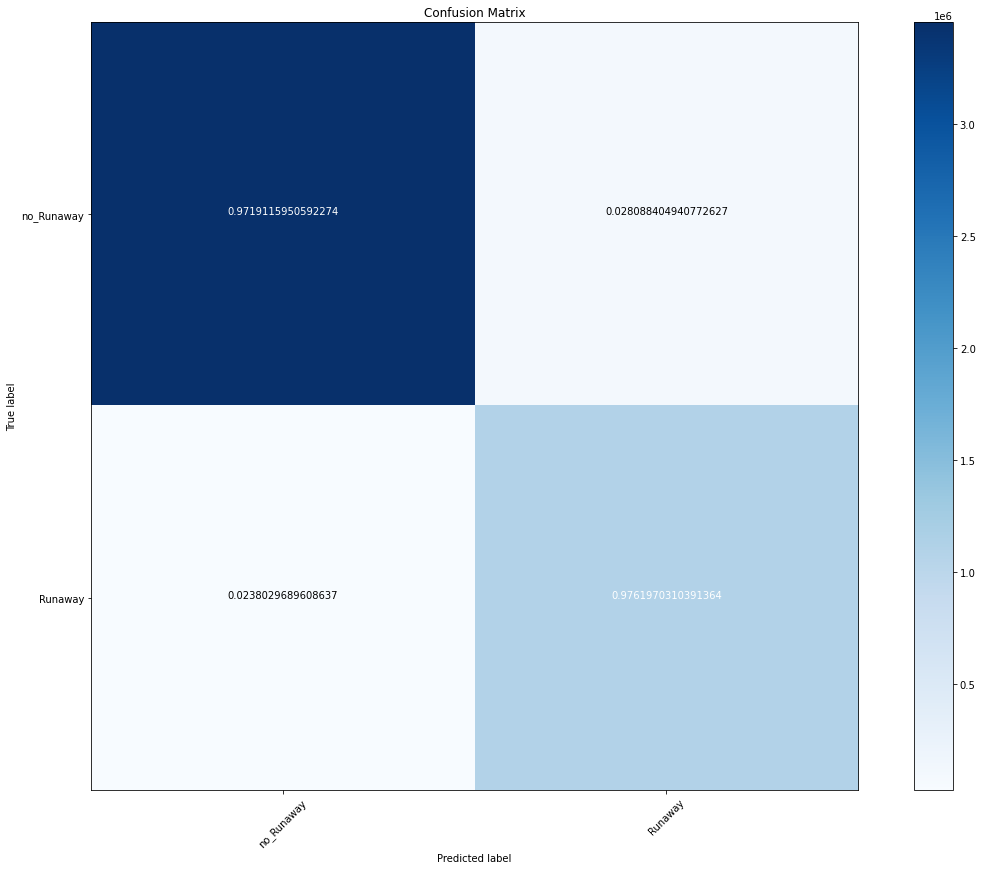

In [24]:
cm = confusion_matrix(y_true=X_reduced.iloc[:,-1], y_pred=clf2.predict(X_reduced.iloc[:,:-1]).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# RandomForest

In [26]:
clf3 = RandomForestClassifier(n_estimators=300, criterion='entropy',
                              max_depth=5, random_state=0).fit(Train_dataset_PCA, Train_dataset_PCA_Labels)

In [27]:
clf3.score(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced) # Train Acc

0.8603953322219576

In [30]:
clf3.score(Test_dataset_PCA_reduced,Test_dataset_PCA_Labels_reduced) # Test Acc

0.868838405486498

Normalized confusion matrix
[[0.99865592 0.00134408]
 [0.27492218 0.72507782]]


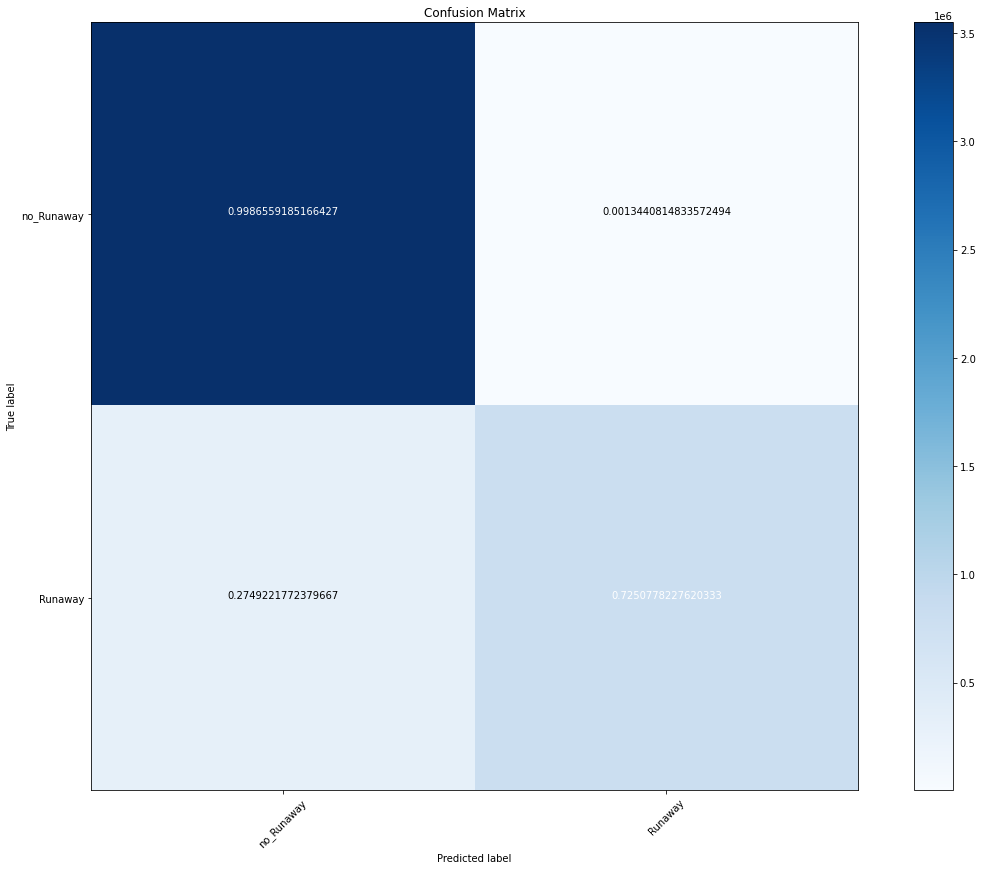

In [29]:
cm = confusion_matrix(y_true=X_reduced.iloc[:,-1], y_pred=clf3.predict(X_reduced.iloc[:,:-1]).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# XGBoost

## Primeiro treino PCA Reduzido

In [31]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2, max_depth=6, learning_rate=0.25,n_estimators=100,random_state=0)


In [32]:
xgb_model.fit(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced,
              eval_set=[(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced),(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[23:31:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.982152	validation_0-error:0.074923	validation_1-auc:0.981715	validation_1-error:0.073082
[23:31:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.987191	validation_0-error:0.062015	validation_1-auc:0.986041	validation_1-error:0.065152
[23:31:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.988997	validation_0-error:0.056752	validation_1-auc:0.987926	validation_1-error:0.06108
[23:31:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.989899	validation_0-error:0.052727	validation_1-auc:0.989099	validation_1-error:0.057222
[23:31:29] INFO: /workspace/src/tree

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

Normalized confusion matrix
[[0.96924875 0.03075125]
 [0.01773729 0.98226271]]


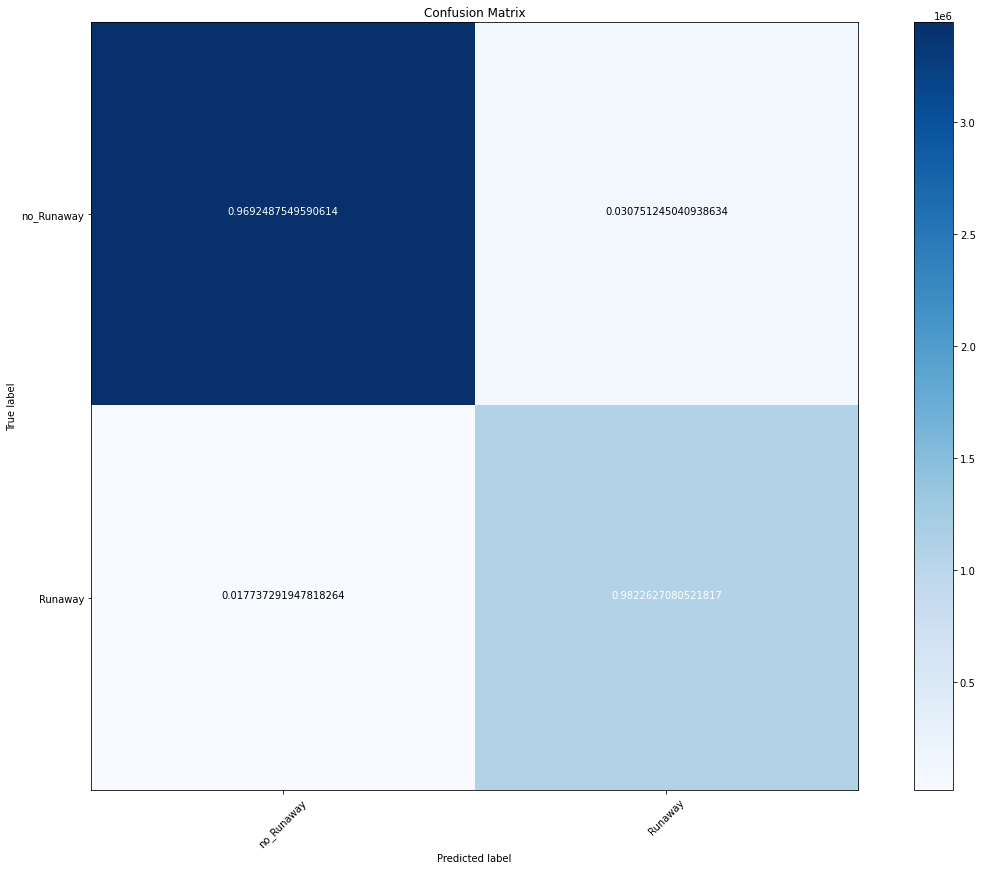

In [33]:
cm = confusion_matrix(y_true=X_reduced.iloc[:,-1], y_pred=xgb_model.predict(X_reduced.iloc[:,:-1]).round()) # Whole DataSet CM
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

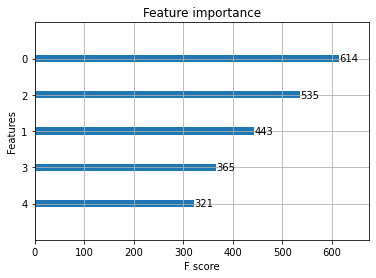

In [34]:
xgb.plot_importance(xgb_model)


In [35]:
xgb_model.score(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced)

0.9858299595141701

In [36]:
xgb_model.score(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)

0.9755679382768967

In [37]:
xgb_model.score(X_reduced.iloc[:,:-1],X_reduced.iloc[:,-1]) # 97.2% acc on the whole dataset without any tuning

0.9723491083676269

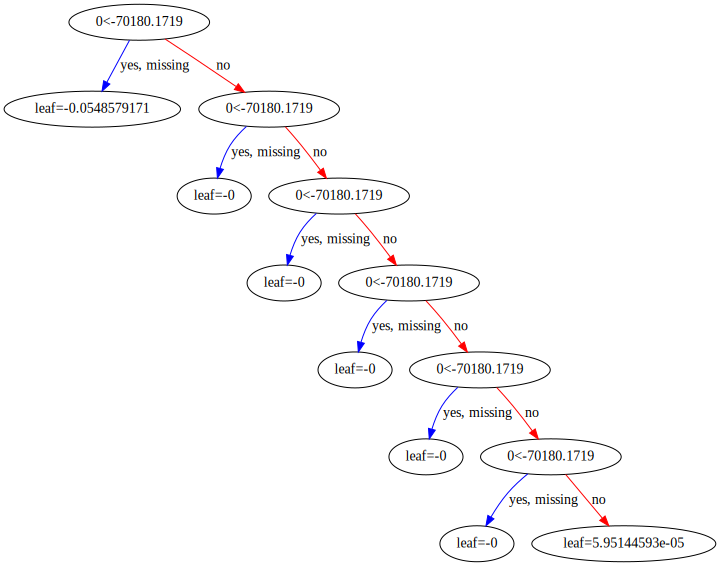

In [44]:
xgb.to_graphviz(xgb_model,num_trees=70)


O modelo afirma fortemente que para a componente principal mais importante ser menor que -70180 A operação é segura

##Primeiro Treino PCA Completo

In [6]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2,max_depth=6,learning_rate=0.25,n_estimators=100, random_state=0)


In [7]:
xgb_model.fit(Train_dataset_PCA, Train_dataset_PCA_Labels,
              eval_set=[(Train_dataset_PCA, Train_dataset_PCA_Labels),(Test_dataset_PCA, Test_dataset_PCA_Labels)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[23:38:30] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[23:38:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.980883	validation_0-error:0.056912	validation_1-auc:0.980475	validation_1-error:0.085112
[23:38:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.983265	validation_0-error:0.05429	validation_1-auc:0.983006	validation_1-error:0.082776
[23:38:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.984958	validation_0-error:0.054865	validation_1-auc:0.984686	validation_1-error:0.089956
[23:39:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

Normalized confusion matrix
[[0.99515604 0.00484396]
 [0.03853738 0.96146262]]


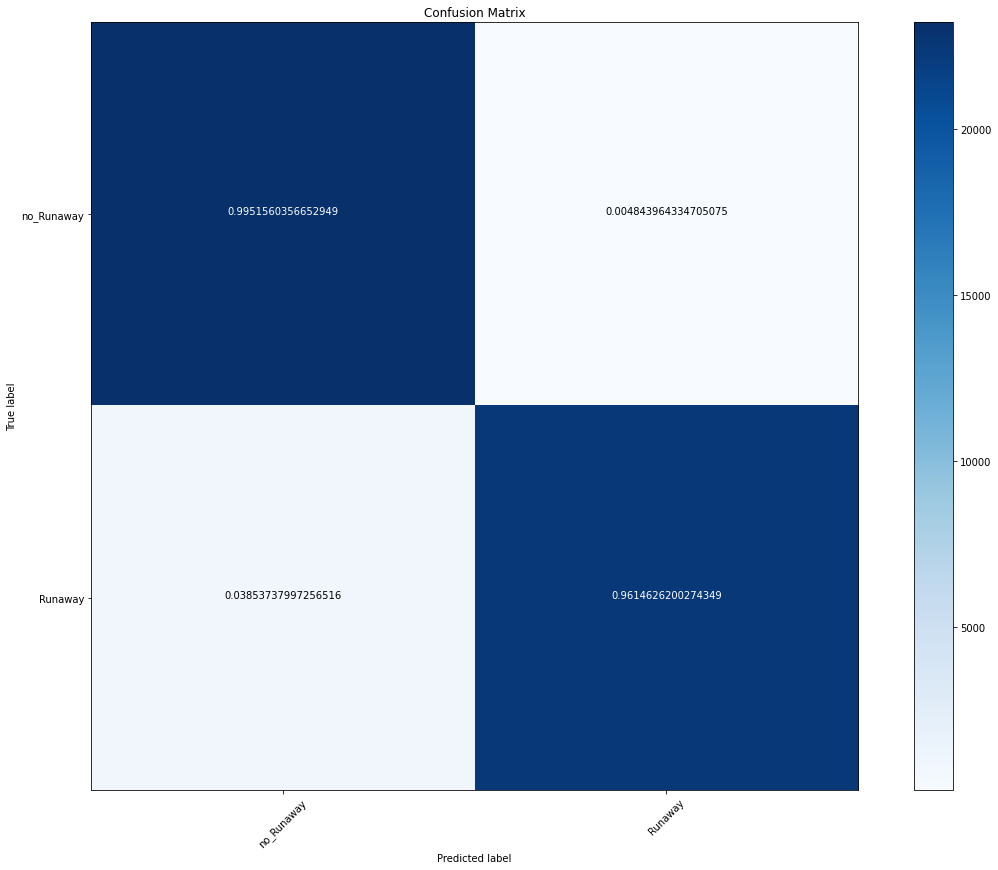

In [10]:
cm = confusion_matrix(y_true=Test_dataset_PCA_Labels, y_pred=xgb_model.predict(Test_dataset_PCA).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

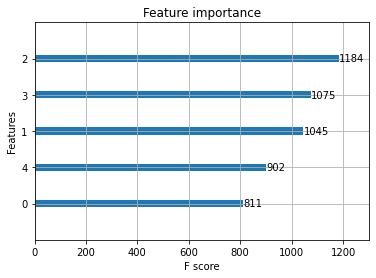

In [11]:
xgb.plot_importance(xgb_model)


In [18]:
xgb_model.score(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced)

0.9783758037628006

In [19]:
xgb_model.score(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)

0.9777111015859409

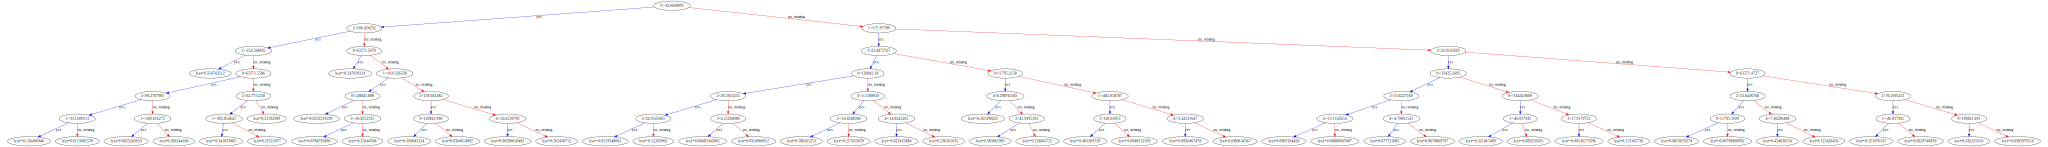

In [20]:
xgb.to_graphviz(xgb_model,num_trees=99)


##Primeiro treino Normal Reduzido

In [21]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2, max_depth=3, learning_rate=0.1,n_estimators=100,random_state=0 )


In [22]:
xgb_model.fit(Train_dataset_Reduced, Train_dataset_Labels_Reduced,
              eval_set=[(Train_dataset_Reduced, Train_dataset_Labels_Reduced),(Test_dataset_reduced, Test_dataset_Labels_reduced)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[00:03:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-auc:0.962944	validation_0-error:0.094784	validation_1-auc:0.962187	validation_1-error:0.100514
[00:03:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-auc:0.981785	validation_0-error:0.079019	validation_1-auc:0.980383	validation_1-error:0.083798
[00:03:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-auc:0.987133	validation_0-error:0.061181	validation_1-auc:0.985981	validation_1-error:0.065795
[00:03:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	validation_0-auc:0.98578	validation_0-error:0.062086	validation_1-auc:0.984138	validation_1-error:0.067938
[00:03:35] INFO: /workspace/src/tree/

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

In [23]:
xgb_model.predict(Train_dataset_Reduced).round()

array([0, 0, 1, ..., 0, 0, 1])

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


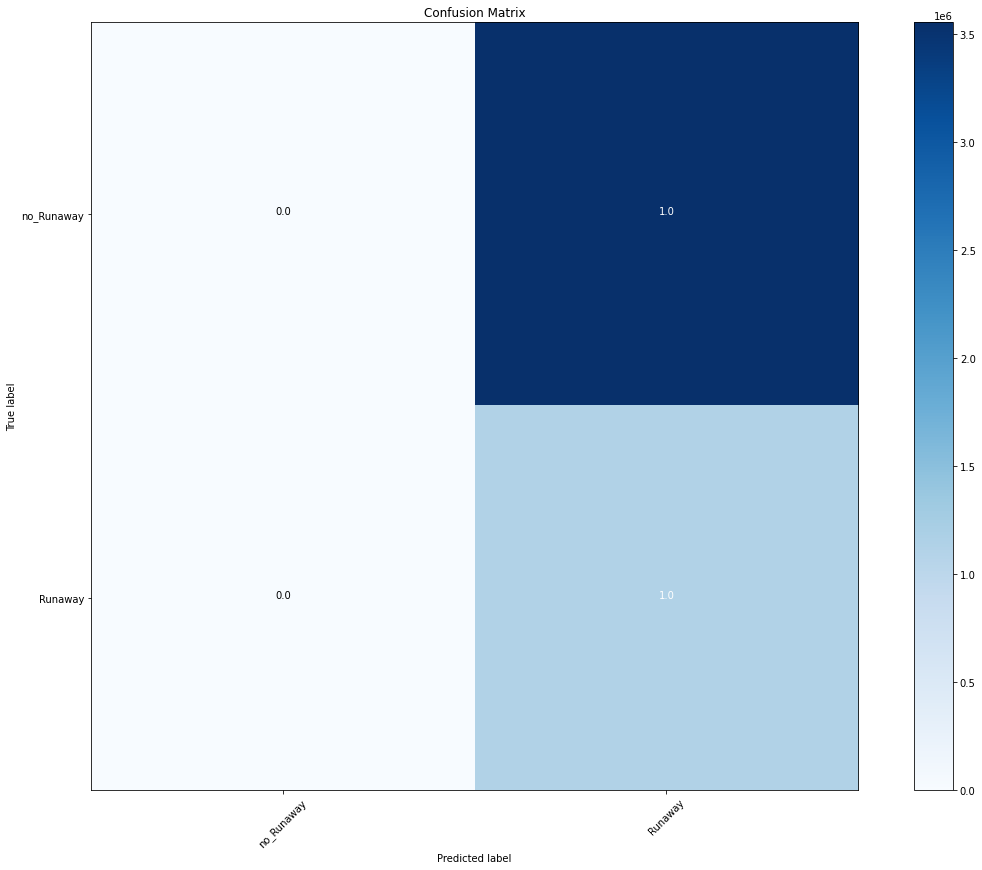

In [24]:
cm = confusion_matrix(y_true=dados_crus.iloc[:,-1], y_pred=xgb_model.predict(dados_crus.iloc[:,:-1].values).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

**Por incrível que pareça, treinar o XGBoost no dataset comum reduzido faz as respostas saírem só 1 , testei várias vezes.
Por erro de ponto flutuante o python diz que não há predições diferentes de 1, quando na verdade a árvore memorizou as instâncias de operação normal dadas. 
Nota de repúdio à como o python trata números pequenos rsrs**


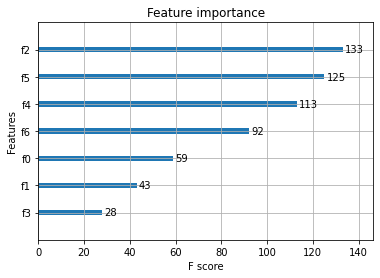

In [25]:
xgb.plot_importance(xgb_model)


In [26]:
xgb_model.score(Train_dataset_Reduced, Train_dataset_Labels_Reduced)

0.9859966658728269

In [27]:
xgb_model.score(Test_dataset_reduced, Test_dataset_Labels_reduced)

0.9841405915130733

In [28]:
xgb_model.score(dados_crus.iloc[:,:-1].values,dados_crus.iloc[:,-1]) 

0.23823302469135801

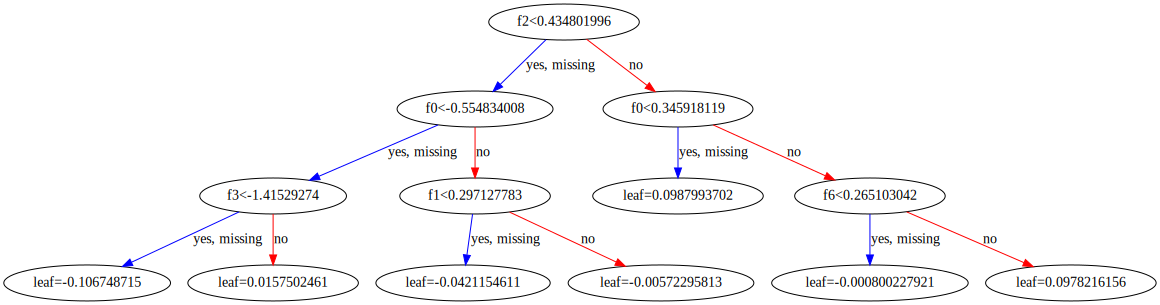

In [29]:
xgb.to_graphviz(xgb_model,num_trees=99)


##Primeiro treino Normal Completo

In [30]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2,colsample_bytree=1, gamma=0.2, learning_rate=0.48, max_depth=6, n_estimators=100, random_state=0)


In [31]:
xgb_model.fit(Train_dataset, Train_dataset_Labels,
              eval_set=[(Train_dataset, Train_dataset_Labels),(Test_dataset, Test_dataset_Labels)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[00:07:26] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[00:07:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.99546	validation_0-error:0.027329	validation_1-auc:0.875263	validation_1-error:0.270319
[00:07:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.997629	validation_0-error:0.019933	validation_1-auc:0.854691	validation_1-error:0.258981
[00:07:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.998068	validation_0-error:0.016138	validation_1-auc:0.882646	validation_1-error:0.269247
[00:08:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree p

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.48, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


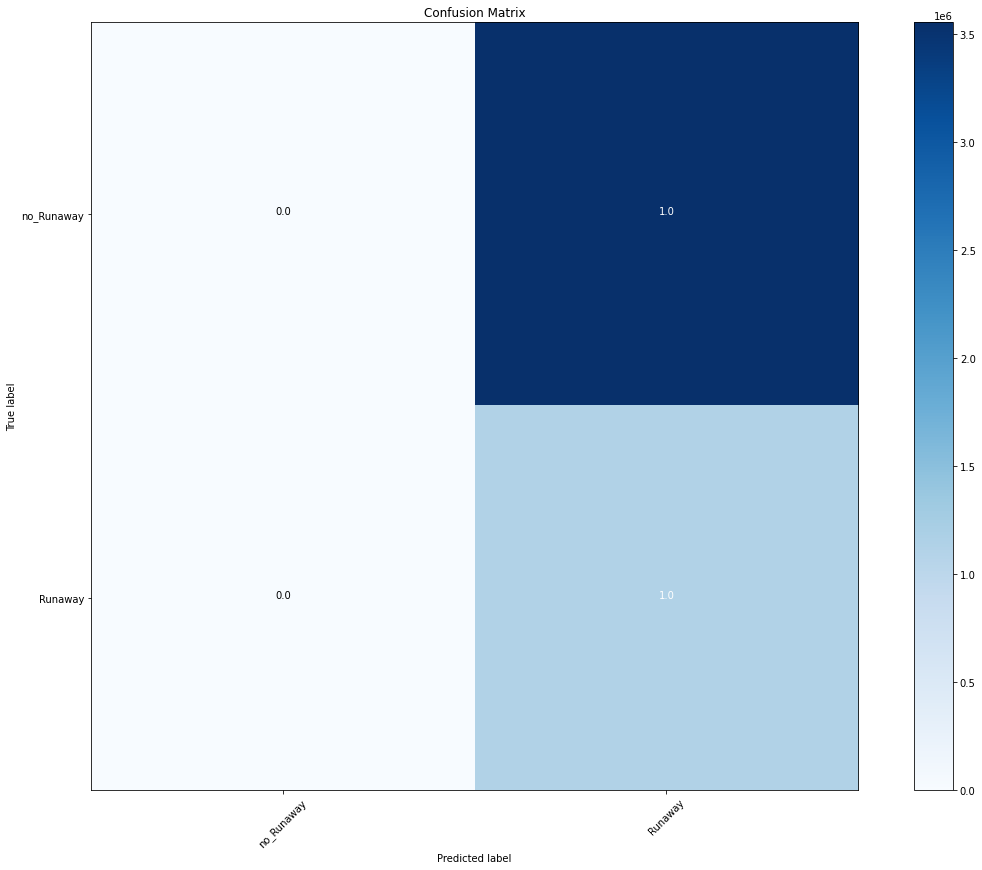

In [32]:
cm = confusion_matrix(y_true=dados_crus.iloc[:,-1], y_pred=xgb_model.predict(dados_crus.iloc[:,:-1].values).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

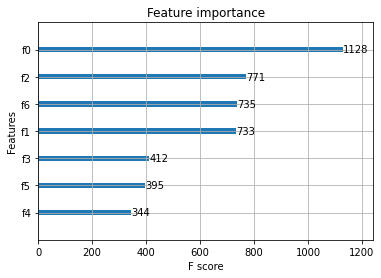

In [33]:
xgb.plot_importance(xgb_model)


In [34]:
xgb_model.score(Train_dataset_Reduced, Train_dataset_Labels_Reduced)

0.7412717313646107

In [35]:
xgb_model.score(Test_dataset_reduced, Test_dataset_Labels_reduced)

0.7434633519074153

In [36]:
xgb_model.score(dados_crus.iloc[:,:-1].values,dados_crus.iloc[:,-1]) 

0.23823302469135801

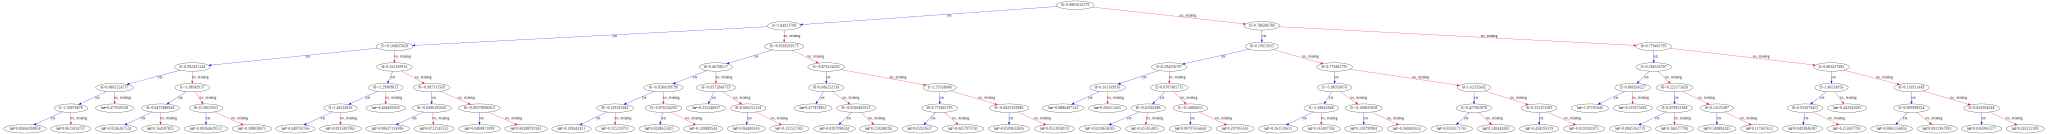

In [37]:
xgb.to_graphviz(xgb_model,num_trees=99)


## Fine tunning

## 1° "Round" PCA Reduzido

In [38]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2,random_state=0)


In [39]:
params = {
    "colsample_bytree": [0.6,1,0.85,0.7],
    "gamma": [0.2,0.3,0.1],
    "learning_rate": [0.36,0.48], # default 0.1 
    "max_depth": [4,5,6], # default 3
    "n_estimators": [170,200], # default 100
}

In [40]:
search = GridSearchCV(xgb_model, param_grid=params,scoring=['f1','recall','accuracy'],cv=5, verbose=3, return_train_score=True,refit='accuracy')

search.fit(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] colsample_bytree=0.6, gamma=0.2, learning_rate=0.36, max_depth=4, n_estimators=170 
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[00:32:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:32:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[00:32:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:32:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nod

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[00:32:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[00:32:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[00:32:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:32:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[00:32:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[00:32:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:32:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:32:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nod

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


A saída de streaming foi truncada nas últimas 5000 linhas.
[01:25:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[01:25:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[01:25:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[01:25:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[01:25:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[01:25:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[01:25:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[01:25:35] INFO: /workspace/src/tree/update

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 54.7min finished


[01:27:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[01:27:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[01:27:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 6 pruned nodes, max_depth=6
[01:27:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[01:27:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[01:27:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[01:27:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[01:27:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nod

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=2),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 1, 0.85, 0.7],
                         'gamma': [0.2, 0.3, 0.1],
                         'learning_rate': [0.36, 0.48], 'max

In [41]:
search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0.1,
              learning_rate=0.48, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

In [42]:
search.best_score_

0.9803524648725886

In [43]:
search.best_params_

{'colsample_bytree': 0.85,
 'gamma': 0.1,
 'learning_rate': 0.48,
 'max_depth': 6,
 'n_estimators': 200}

In [44]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2,colsample_bytree=0.85, gamma=0.1, learning_rate=0.48, max_depth=6, n_estimators=200,random_state=0)

In [45]:
xgb_model.fit(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced,
              eval_set=[(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced),(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[01:28:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.980676	validation_0-error:0.078757	validation_1-auc:0.979995	validation_1-error:0.081655
[01:28:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.986995	validation_0-error:0.062682	validation_1-auc:0.986797	validation_1-error:0.064724
[01:28:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.990176	validation_0-error:0.054561	validation_1-auc:0.989796	validation_1-error:0.05808
[01:28:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.991601	validation_0-error:0.050703	validation_1-auc:0.990927	validation_1-error:0.051436
[01:28:58] INFO: /workspace/src/tree

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0.1,
              learning_rate=0.48, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

In [46]:
xgb_model.score(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced)

0.9982614908311502

In [47]:
xgb_model.score(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)

0.9802828975567939

Normalized confusion matrix
[[0.97879126 0.02120874]
 [0.01511381 0.98488619]]


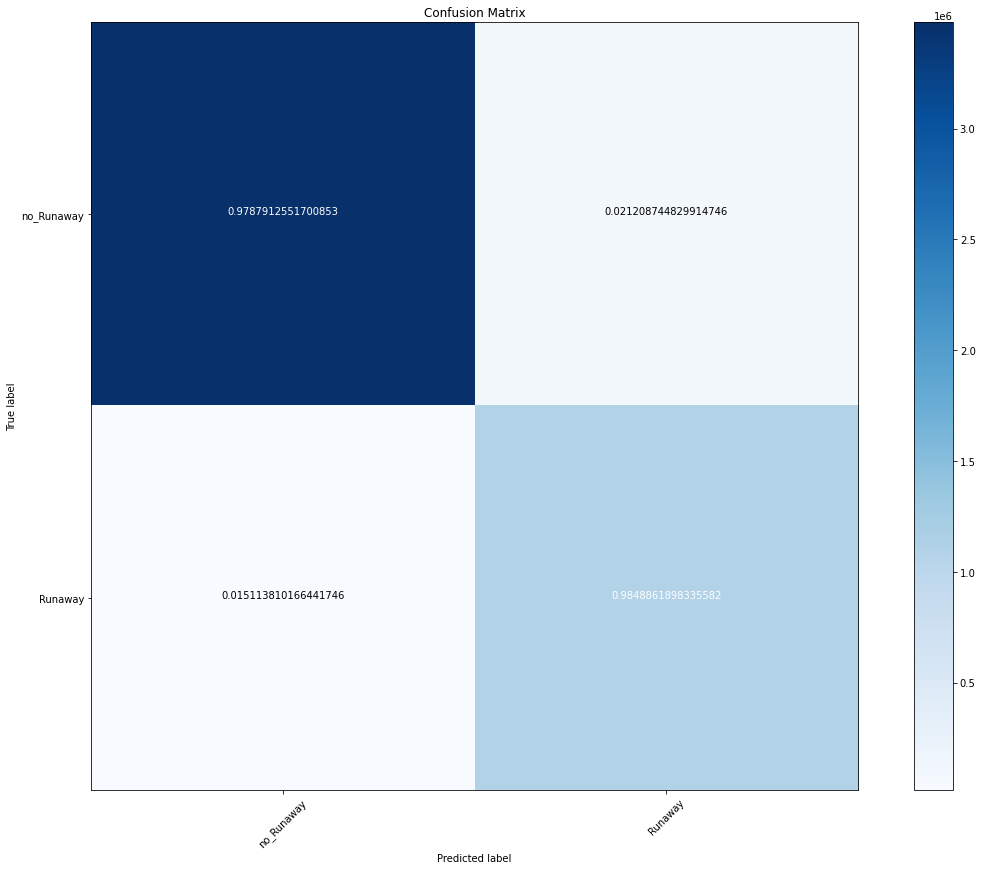

In [48]:
cm = confusion_matrix(y_true=X_reduced.iloc[:,-1], y_pred=xgb_model.predict(X_reduced.iloc[:,:-1]).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

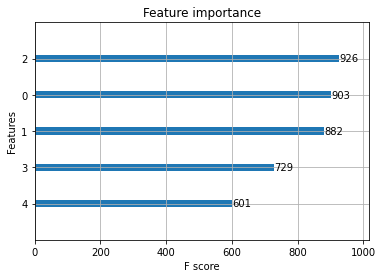

In [49]:
xgb.plot_importance(xgb_model, ax=None
                    , height=0.2, xlim=None, ylim=None, title='Feature importance'
                    , xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, grid=True, show_values=True)


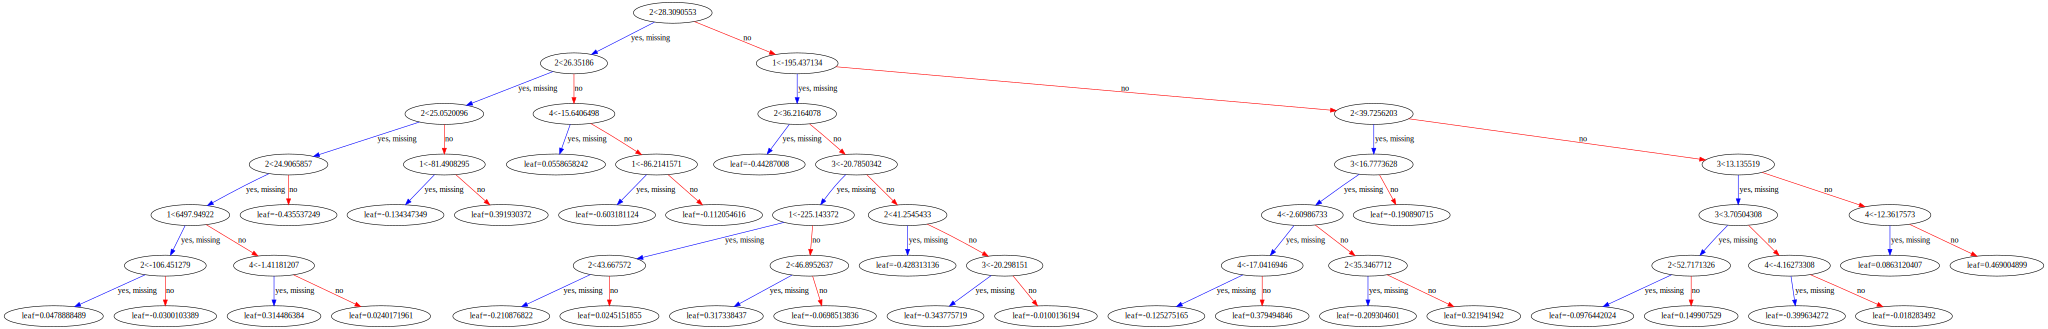

In [54]:
xgb.to_graphviz(xgb_model,num_trees=90)

In [55]:
xgb_model.score(X_reduced.iloc[:,:-1],X_reduced.iloc[:,-1])

0.9802432698902607

In [56]:
xgb_model.save_model('XGBoost')

In [ ]:
xgb_model.load_model('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/XGBoost')